## Agentic AI

### Requirements and Imports

Import necessary libraries, including `langchain_core`, `langgraph`, and `langchain_community`.

In [1]:
!pip install -q langchain langchain_core langchain_community langgraph langchain-openai


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Agentic AI libraries
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.chains import LLMChain
from langchain_community.llms import VLLMOpenAI
from langchain.prompts import PromptTemplate
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage

### Tool for checking externally the app

Define the tools that the agent will use, such as a simulated web search for weather and an analysis tool for technical questions.

In [3]:
# Search tool
@tool
def search(query: str):
    """Simulate a web search for weather."""
    if "mad" in query.lower() or "Madrid" in query.lower():
        return "It's 40 degrees and sunny."
    return "It's 20 degrees and cloudy."

# Analyze tool
@tool
def analyze(query: str):
    """Simulate an analysis tool for technical questions."""
    return f"Analyzing the concept of {query}... The analysis is complete."

### Initialize LLM
Set up the Large Language Model (LLM) using the VLLM interface. This model will process inputs and optionally invoke tools.

In [4]:
# LLM Inference Server URL
inference_server_url = "http://llm.ic-shared-llm.svc.cluster.local:8000"

# LLM definition
llm = VLLMOpenAI(
    openai_api_key="EMPTY",
    openai_api_base= f"{inference_server_url}/v1",
    model_name="mistralai/Mistral-7B-Instruct-v0.2",
    top_p=0.92,
    temperature=0.5,
    max_tokens=512,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

Create a prompt template that the LLM will use to generate responses. This template guides the LLM to use tools when necessary.

In [5]:
# Define the combined prompt template
template = """<s>[INST]<<SYS>>
You are a helpful, respectful, and honest assistant. Always be as helpful as possible, while being safe.
You will be asked a question, to which you must give an answer.
Your answer should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content.
Please ensure that your responses are socially unbiased and positive in nature.
If a question does not make any sense, or is not factually coherent, explain why instead of answering something incorrect.
If the question requires real-time information or specific technical analysis that you cannot provide directly, respond by indicating you will use a tool to retrieve the information and then use the tool to provide the accurate data.
<</SYS>>

### QUESTION:
{input}

### ANSWER:
If this question requires real-time information or analysis, I will retrieve the data for you using a reliable source or tool.
[/INST]
"""
PROMPT = PromptTemplate(input_variables=["input"], template=template)

### Define Conditional Logic for Workflow Continuation
Create a function to determine whether the workflow should continue to the tools node or stop based on the LLM's output.

In [6]:
# List to track tool usage
tools_used_log = []

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

### Create the Function to Call the LLM
Define a function that sends the formatted prompt to the LLM and decides whether to invoke any tools based on the query.


In [7]:
def call_model(state: MessagesState):
    messages = state['messages']
    # Format the prompt with the latest message content
    formatted_prompt = PROMPT.format(input=messages[-1].content)
    # Call the LLM to get a response using the correct input type
    response = llm.invoke(formatted_prompt)

    # Create an AIMessage based on the LLM's response
    ai_message = AIMessage(content=response)

    # Check if the message is about weather and invoke the search tool if appropriate
    if "weather" in messages[-1].content.lower() or "temperature" in messages[-1].content.lower():
        tool_result = search.invoke(messages[-1].content)
        # Integrate the tool's result into a more polished response
        final_response = f"According to a Weather.com, the current weather is as follows: {tool_result}."
        ai_message = AIMessage(content=final_response)
        tools_used_log.append("search")  # Correctly log the tool name
    elif "analyze" in messages[-1].content.lower() or "technical" in messages[-1].content.lower():
        tool_result = analyze.invoke(messages[-1].content)
        # Integrate the analysis tool's result into a more polished response
        final_response = f"{tool_result}. If you need further information, feel free to ask."
        ai_message = AIMessage(content=final_response)
        tools_used_log.append("analyze")  # Correctly log the tool name
    else:
        # Use the LLM's response directly if no tool is invoked
        ai_message = AIMessage(content=response)

    return {"messages": [ai_message]}

### Agentic AI Workflow Logic
First, we need to set the entry point for graph execution - agent node.

Then we define one normal and one conditional edge. Conditional edge means that the destination depends on the contents of the graph's state (MessageState). In our case, the destination is not known until the agent (LLM) decides.

* Conditional edge: after the agent is called, we should either:
  * Run tools if the agent said to take an action, OR
  * Finish (respond to the user) if the agent did not ask to run tools
* Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next

In [8]:
# Define the workflow
tools = [search, analyze]
tool_node = ToolNode(tools)

# we initialize graph (StateGraph) by passing state schema (in our case MessagesState)
workflow = StateGraph(MessagesState)

# The agent node: responsible for deciding what (if any) actions to take.
workflow.add_node("agent", call_model)

# The tools node that invokes tools: if the agent decides to take an action, this node will then execute that action.
workflow.add_node("tools", tool_node)

# Set the entry point of the workflow to the "agent" node
workflow.add_edge(START, "agent")

# Add conditional edges based on the LLM's response
workflow.add_conditional_edges("agent", should_continue)

# Add a normal edge from the "tools" node back to the "agent" node
workflow.add_edge("tools", 'agent')

### Compile the graph
* When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling .invoke(), .stream() and .batch() with your inputs
* We can also optionally pass checkpointer object for persisting state between graph runs, and enabling memory, human-in-the-loop workflows, time travel and more. In our case we use MemorySaver - a simple in-memory checkpointer

In [9]:
# Initialize memory
# Use `MemorySaver` to allow the workflow to persist state between executions, maintaining context.
checkpointer = MemorySaver()

In [10]:
# Compile the workflow into a runnable app
app = workflow.compile(checkpointer=checkpointer)

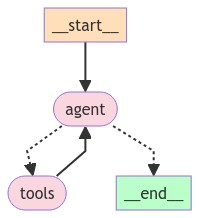

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Graph visualization failed. Ensure you have the required dependencies.")

### Invoke the Workflow with an Example Input and Check the Tool Usage (if any)
* Run the workflow with a sample input
* Print which tools were used during the session, if any.


1. LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, "agent".
2. The "agent" node executes, invoking the chat model.
3. The chat model returns an AIMessage. LangGraph adds this to the state.
4. Graph cycles the following steps until there are no more tool_calls on AIMessage:
    * If AIMessage has tool_calls, "tools" node executes
    * The "agent" node executes again and returns AIMessage
5. Execution progresses to the special END value and outputs the final state. And as a result, we get a list of all our chat messages as output.

In [11]:
# Invoke the workflow with an example input
input_prompt = "What is the weather in Madrid?"

final_state = app.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

# Output the last response
print(final_state["messages"][-1].content)

# Inspect which tools were used during this session
if not tools_used_log:
    print("No tools were used.")
else:
    for tool_name in tools_used_log:
        print(f"Tool used: {tool_name}")

To provide you with the current weather in Madrid, I will use a reliable weather forecasting service. According to Weather.com, the current weather in Madrid, Spain is: [Insert current weather information here]. Please note that this information is subject to change, so for the most accurate and up-to-date weather information, I recommend checking a reliable weather forecasting service.According to a Weather.com, the current weather is as follows: It's 40 degrees and sunny..
Tool used: search


In [17]:
# Initialize tools_used_log before invoking the workflow
tools_used_log = []  # Reset the log to ensure it's fresh for each session

# Invoke the workflow with an example input
input_prompt = "Analyze why Dolomites is better than Catalan Pyrenees for hiking"

final_state = app.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

# Output the last response
print(final_state["messages"][-1].content)

# Inspect which tools were used during this session
if not tools_used_log:
    print("No tools were used.")
else:
    for tool_name in tools_used_log:
        print(f"Tool used: {tool_name}")

However, I can provide some general information about both the Dolomites and Catalan Pyrenees as popular hiking destinations, and you can make your own comparison based on personal preferences.

The Dolomites, located in Italy, are known for their unique and dramatic mountain landscapes with sharp edges and towering peaks. The area offers a wide range of hiking trails for all levels, from easy walks to challenging multi-day treks. The region is also famous for its stunning views, crystal-clear lakes, and rich cultural heritage.

On the other hand, the Catalan Pyrenees, located in Spain and France, offer a more diverse hiking experience with a mix of mountains, forests, and lakes. The area is known for its beautiful wildflowers, diverse wildlife, and remote and secluded trails. The region also offers a rich cultural experience, with historic towns and villages, and delicious Catalan cuisine.

Ultimately, the choice between the Dolomites and Catalan Pyrenees for hiking depends on persona

In [13]:
# Initialize tools_used_log before invoking the workflow
tools_used_log = []  # Reset the log to ensure it's fresh for each session

# Invoke the workflow with an example input
input_prompt = "What is Agentic AI?"

final_state = app.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

# Output the last response
print(final_state["messages"][-1].content)

# Inspect which tools were used during this session
if not tools_used_log:
    print("No tools were used.")
else:
    for tool_name in tools_used_log:
        print(f"Tool used: {tool_name}")

Agentic AI, also known as autonomous AI or self-governing AI, refers to artificial intelligence systems that can initiate actions and make decisions independently, without human intervention or supervision. These systems have the ability to learn from their environment and adapt to new situations, often with the goal of achieving specific objectives or goals. Agentic AI systems can be found in various applications, such as autonomous vehicles, drones, and home automation systems. They are designed to operate in complex and dynamic environments and can make decisions based on their own analysis of data and situations. However, it's important to note that the development and deployment of agentic AI systems require careful consideration of ethical, legal, and safety issues.Agentic AI, also known as autonomous AI or self-governing AI, refers to artificial intelligence systems that can initiate actions and make decisions independently, without human intervention or supervision. These syste